# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
#data['dot_graph'] = 'digraph { v ->y;X0-> v;X0-> y;}'

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,0.598909,True,6.603668
1,-1.000436,False,-2.909702
2,-0.762590,False,-2.675324
3,0.674898,True,6.496472
4,-2.141102,False,-7.003684
...,...,...,...
995,-1.800016,False,-4.385415
996,-1.148815,False,-2.907490
997,-1.105429,False,-3.193994
998,-0.423894,True,5.356881


<AxesSubplot: xlabel='v0'>

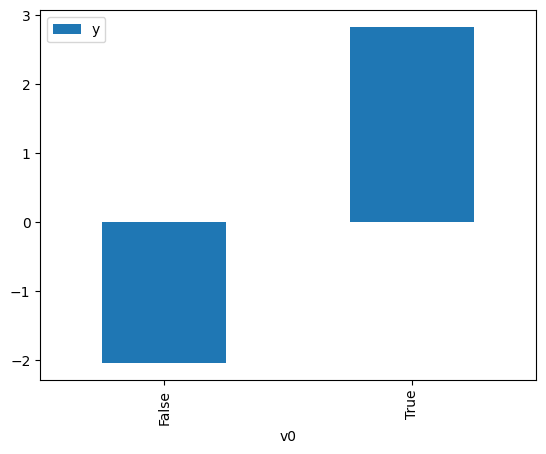

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
                     variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
                     outcome=outcome,
                     common_causes=[common_cause],
                     proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

<AxesSubplot: xlabel='v0'>

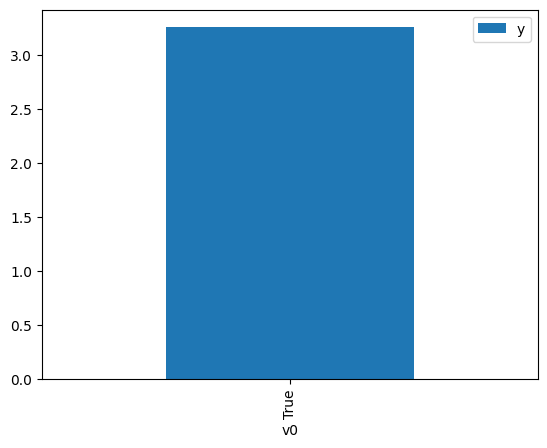

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause],
              proceed_when_unidentifiable=True).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              dot_graph=data['dot_graph'],
              proceed_when_unidentifiable=True)


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,1.386097,False,3.691658,0.058994,16.951016
1,-2.007019,False,-6.068847,0.983840,1.016425
2,-0.594681,False,-1.940410,0.776585,1.287689
3,0.055470,False,0.938028,0.481983,2.074761
4,0.339775,False,1.943973,0.343342,2.912551
...,...,...,...,...,...
995,-0.472033,False,-1.989297,0.730517,1.368894
996,-0.111262,False,-0.981572,0.566086,1.766518
997,-0.196767,False,-0.735517,0.608076,1.644531
998,-2.054935,False,-5.627801,0.985314,1.014905


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,0.170149,True,5.017203,0.575560,1.737437
1,0.828068,True,8.472136,0.837303,1.194311
2,-1.262914,True,2.871409,0.069106,14.470549
3,-0.898102,True,1.931534,0.134591,7.429942
4,-0.060574,True,4.777845,0.459304,2.177207
...,...,...,...,...,...
995,-1.835211,True,-0.294381,0.022739,43.976637
996,0.190233,True,5.347509,0.585474,1.708016
997,0.438420,True,6.100254,0.700233,1.428096
998,-0.119792,True,3.282433,0.429672,2.327357


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.950
Model:                            OLS   Adj. R-squared (uncentered):              0.950
Method:                 Least Squares   F-statistic:                              9472.
Date:                Mon, 17 Oct 2022   Prob (F-statistic):                        0.00
Time:                        14:03:48   Log-Likelihood:                         -1441.7
No. Observations:                1000   AIC:                                      2887.
Df Residuals:                     998   BIC:                                      2897.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.7483      0.028     99.040      0.000       2.694       2.803
x2             5.0991      0.060     85.556      0.000       4.982       5.216
==============================================================================
Omnibus:                        1.522   Durbin-Watson:                   2.062
Prob(Omnibus):                  0.467   Jarque-Bera (JB):                1.599
Skew:                           0.082   Prob(JB):                        0.450
Kurtosis:                       2.894   Cond. No.                         2.16
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""